In [461]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [462]:
# 이더리움 데이터 불러오기
modify_data = pd.read_csv('../data/sub_upbit_eth_min_tick.csv', index_col='time', parse_dates=True)

In [463]:
print(modify_data.shape)
modify_data.head()

(1000000, 5)


,open,high,low,close,volume
time,,,,,
2017-09-25 03:00:00,324500,325500,322000,324000,52.477251
2017-09-25 03:01:00,324000,324000,322500,324000,39.061889
2017-09-25 03:02:00,322500,324500,322500,324500,12.794000
2017-09-25 03:05:00,324000,324000,323000,324000,33.365246
2017-09-25 03:06:00,324000,325000,322500,324000,46.224544


- 데이터 1,000,000 개
- time을 보니 일정한 시간간격으로 측정된 것은 아님

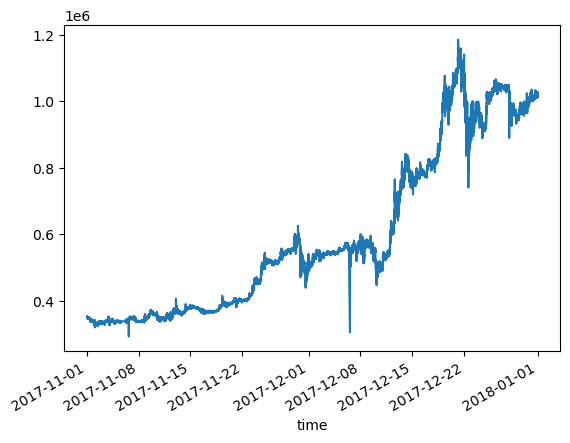

In [464]:
# 일부 기간의 종가 시각화
modify_data.loc['2017-11-01':'2017-12-31', 'close'].plot()
plt.show()

# Data Labeling (추세 라벨링)
- Price Change Direction
- Using Moving Average
- Local Min-Max
- Trend Scanning

### Price Change Direction
- 현재 가격과 특정 시점 이전의 가격 차이로 Labeling

In [465]:
# 10개 시점 전 data와 가격 비교
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window))+1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # 이전 시점의 종가보다 크거나 같으면 1, 작으면 0으로 입력된 데이터

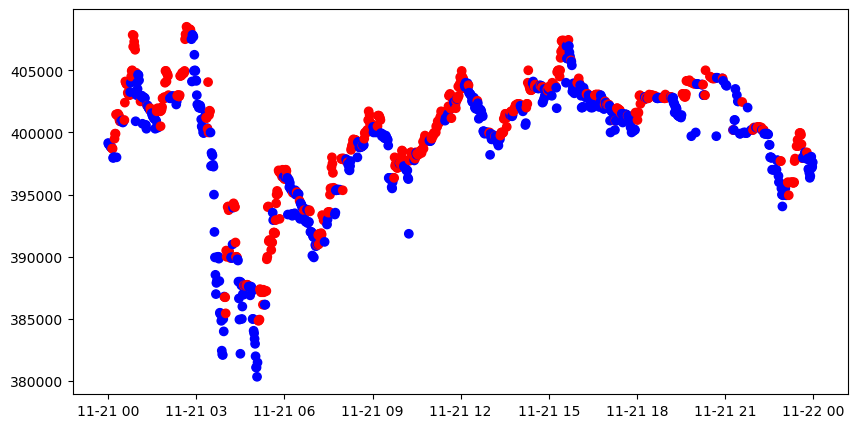

In [466]:
# 2017-11-21 데이터 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue') # 데이터 1이면 red, 0이면 blue

plt.figure(figsize=(10, 5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])
plt.show()

### Using Moving Average
- 현재 주가가 이동평균선 위에있는지 아래있는지로 Labeling

In [467]:
# 10개 시점 구간으로 계산한 이동평균 이용
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

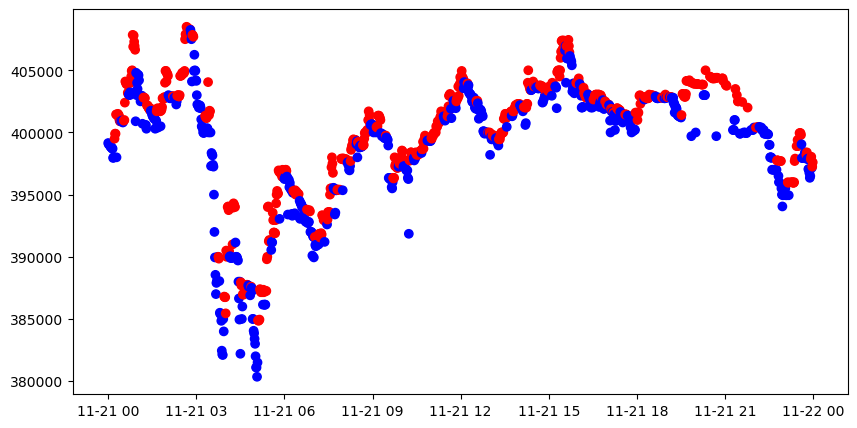

In [468]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10, 5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])
plt.show()

### Local Min-Max
- 국지적인 최소/최댓값 갱신하여, 최소-최대 구간 이어나가며 Labeling
- 현재 가격이 감소중이라면 최솟값 계속 갱신
- 만약 가격이 증가하기 시작했다면 최솟값 갱신 중단. 현재 최솟값을 최댓값으로 두고 최댓값 계속 갱신
- 단, 가격이 한 번 증가했다고 바로 최소-최대 갱신을 변환하면 빈번한 labeling 변화 발생하므로, wait 계수 설정 가능

In [469]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [470]:
mins, maxes = get_local_min_max(sub_data, wait=3)

(376546.5, 412585.0)

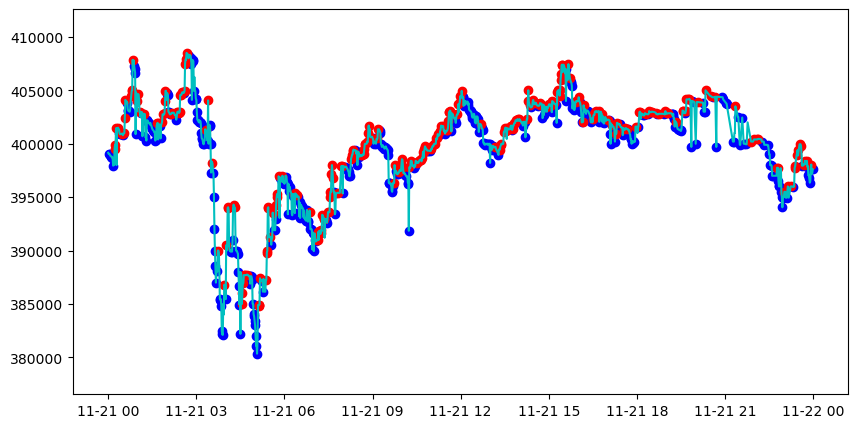

In [471]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

(376546.5, 412585.0)

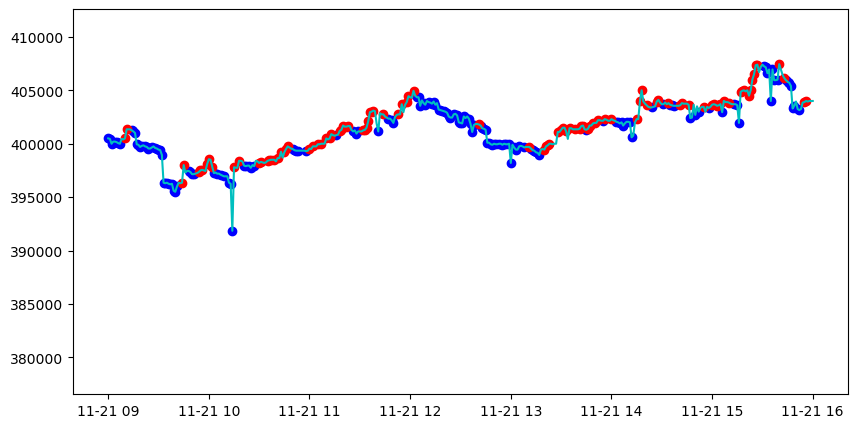

In [472]:
# 2017-11-21 집중 시각화
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min()*0.99, sub_data.max() * 1.01])

### Trend Scanning
- 회귀식과 t-value 이용해 labeling

In [473]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    # linear trend로부터 t-value 추출
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [474]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [277]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continuer
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|████████████████████████████████████████████████████████████████████████████| 33384/33384 [07:45<00:00, 71.78it/s]


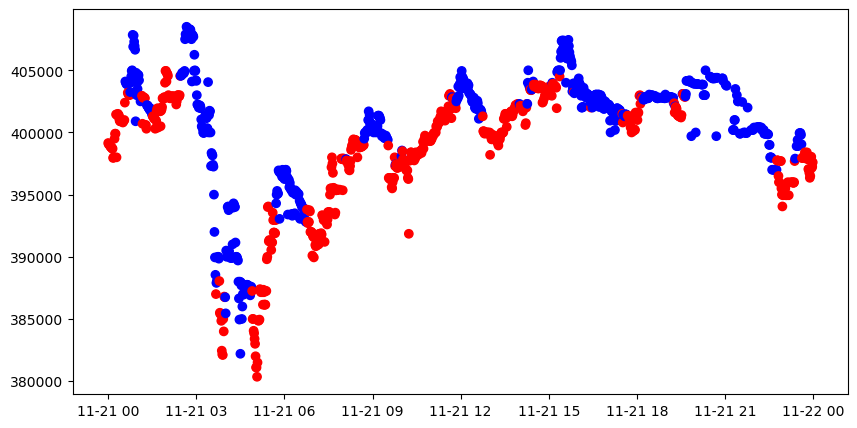

In [475]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# Feature Engineering

In [279]:
!pip install ta==0.9.0
!pip install shap

In [280]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
import sys
sys.path.append('/Users/cyj1226/modu/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [483]:
df_modify_data = pd.read_csv('../data/sub_upbit_eth_min_tick.csv', index_col=0, parse_dates=True)
df_label_data = pd.read_pickle('../data/sub_upbit_eth_min_tick_label.pkl')
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축 위해 1000개 데이터만 추출
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [484]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [485]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [486]:
df_label_data.value_counts()

t_value
-1.0    306636
-0.0    302963
 1.0    299289
Name: count, dtype: int64

#### Technical Index 추가

In [487]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [488]:
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


In [489]:
# 수익률/변동성 지표 적용
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [490]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [491]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [492]:
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671


In [493]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

In [494]:
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)

In [495]:
feat_imp

,mean,std
volume_cmf,0.050760,0.002195
volume_fi,0.044998,0.002535
volume_mfi,0.043081,0.002535
volume_sma_em,0.037157,0.001963
volume_vpt,0.026634,0.001510
volatility_atr,0.079536,0.003300
volatility_ui,0.049669,0.002638
trend_macd_diff,0.067013,0.003538
trend_adx,0.052219,0.002339
trend_trix,0.066450,0.002914


In [496]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [497]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    plt.show()

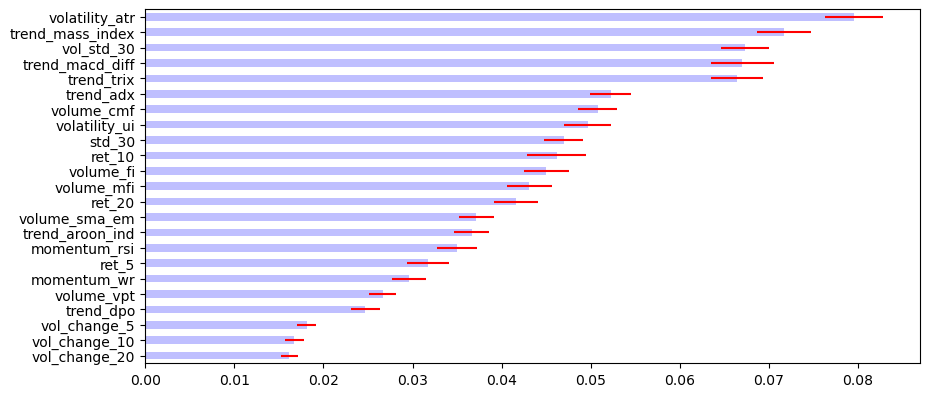

In [498]:
plot_feature_importance(feat_imp)

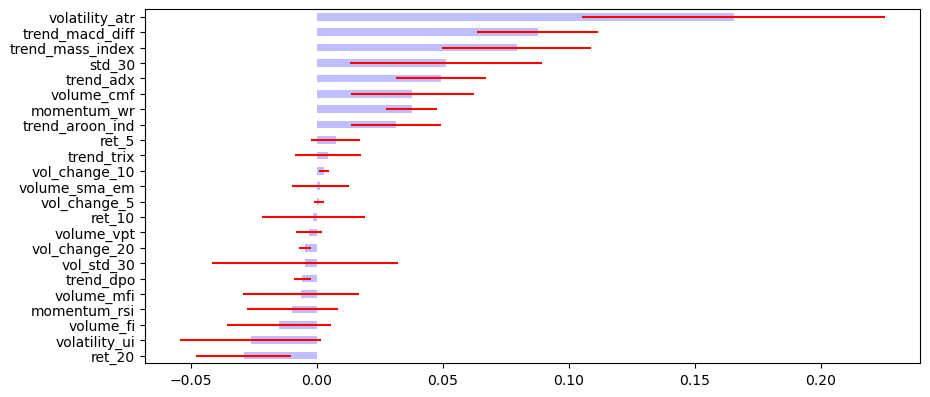

In [499]:
plot_feature_importance(feat_imp_mda)

In [500]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [299]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0: 'Optimal_Features', 1:'Ranking'})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [300]:
rfe_df[rfe_df['Optimal_Features']==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


In [501]:
# Sequential Feature Selection
n = 2

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [502]:
# 선택된 feature 확인
sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

In [503]:
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

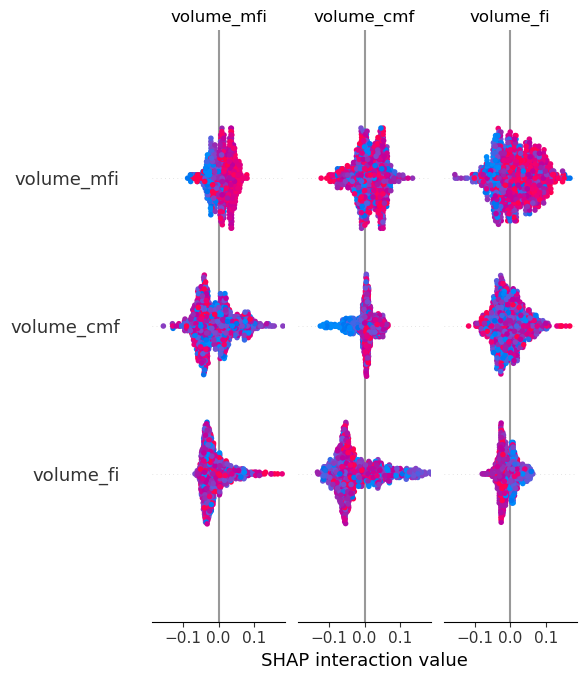

In [504]:
shap.summary_plot(shap_value, X_sc)

# 모델 학습

In [528]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from libs.mlutil.pkfold import PKFold

In [529]:
# 모델 성능 개선 시 반복 수행될 작업이므로, 함수 생성
df_data = pd.read_pickle('../data/sub_upbit_eth_min_feature_labels.pkl')
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x==1 else 0)
sc = StandardScaler()

def data_split(train_ratio, test_ratio):
    # train, test 데이터 수 계산
    n_train = int(np.round(len(df_data) * train_ratio))
    n_test = int(np.round(len(df_data) * test_ratio))

    # feature, target 분할
    X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]
    X_sc = sc.fit_transform(X)

    # train, test 분할
    train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]
    train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
    train_y = pd.Series(train_y, index=train_y.index)
    test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
    test_y = pd.Series(test_y, index=test_y.index)

    return train_x, test_x, train_y, test_y

In [530]:
train_x, test_x, train_y, test_y = data_split(0.7, 0.2)

In [531]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
cv = PKFold(n_cv, t1, 0)

In [532]:
bc_params = {
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
            }
             
rfc = RandomForestClassifier(class_weight='balanced', random_state=11)
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 48 candidates, totalling 192 fits


In [533]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=5,
                                                   max_features=None,
                                                   min_samples_leaf=10,
                                                   random_state=11),
                  max_features=0.5)

In [534]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [535]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}')

================= confusion matrix ====================
[[79 57]
 [12 43]]
정확도:0.6387, 정밀도:0.4300, 재현율:0.7818


auc:0.79451871657754


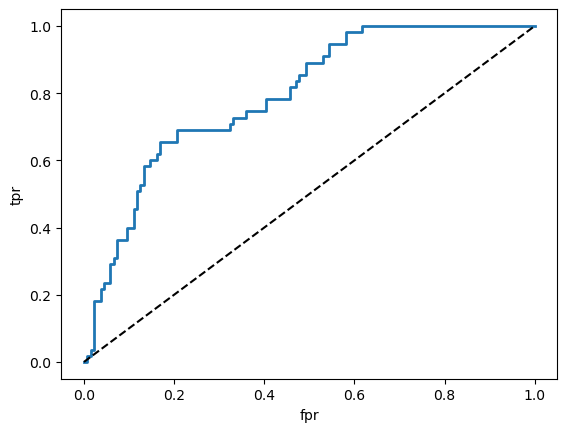

In [536]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

# 개선 
- 기준  
accuracy: 67  
precision: 45  
recall: 76

- 데이터 개수 조절은 현재 데이터 역시 많은 데이터가 아니므로 미시행

## 1. train/test 비율 변경
- train 0.7 test 0.2 => train 0.6, test 0.3

In [537]:
from sklearn.metrics import classification_report

In [538]:
train_x, test_x, train_y, test_y = data_split(0.6, 0.3)

In [539]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
cv = PKFold(n_cv, t1, 0)

In [540]:
bc_params = {
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
            }
             
rfc = RandomForestClassifier(class_weight='balanced', random_state=11)
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 48 candidates, totalling 192 fits


In [541]:
train_y.value_counts()

t_value
1.0    321
0.0    253
Name: count, dtype: int64

In [542]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=3,
                                                   max_features=None,
                                                   min_samples_leaf=3,
                                                   random_state=11),
                  max_features=0.5)

In [543]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [544]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}')

================= confusion matrix ====================
[[115  69]
 [ 23  80]]
정확도:0.6794, 정밀도:0.5369, 재현율:0.7767


auc:0.7479949345715491


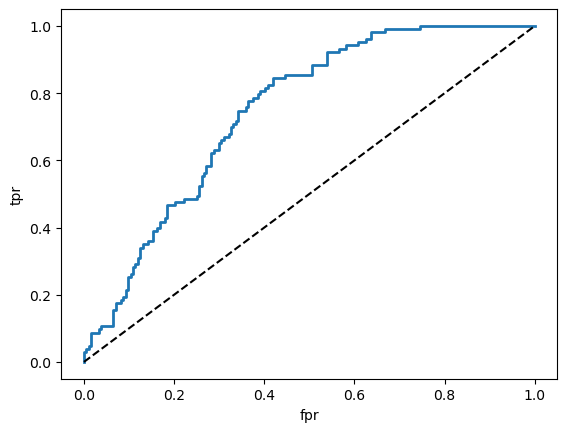

In [545]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

In [546]:
classification_report(test_y, pred_y, output_dict=True)

{'0.0': {'precision': 0.8333333333333334,
  'recall': 0.625,
  'f1-score': 0.7142857142857143,
  'support': 184.0},
 '1.0': {'precision': 0.5369127516778524,
  'recall': 0.7766990291262136,
  'f1-score': 0.6349206349206349,
  'support': 103.0},
 'accuracy': 0.6794425087108014,
 'macro avg': {'precision': 0.6851230425055929,
  'recall': 0.7008495145631068,
  'f1-score': 0.6746031746031746,
  'support': 287.0},
 'weighted avg': {'precision': 0.7269524277217845,
  'recall': 0.6794425087108014,
  'f1-score': 0.6858027763951109,
  'support': 287.0}}

[이전 모델] 정확도:0.6387, 정밀도:0.4300, 재현율:0.7818  
[현재 모델] 정확도:0.6794, 정밀도:0.5369, 재현율:0.7767  
=> 정확도와 정밀도가 증가하였으으며 재현율은 소폭 감소  
=> 0.6, 0.3 비율로 분할하는게 좋아보임  

## 2. 모델 변경 (XGBClassifier), split 개수 변경

In [410]:
# !pip install xgboost

In [547]:
from xgboost import XGBClassifier

In [555]:
train_x, test_x, train_y, test_y = data_split(0.6, 0.3)

n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
cv = PKFold(n_cv, t1, 0)

In [556]:
bc_params = {
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__learning_rate': [0.05, 0.1]
            }
             
xgb = XGBClassifier(n_estimators=500, random_state=11)
bag_xgb = BaggingClassifier(xgb)
gs_xgb = GridSearchCV(bag_xgb, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_xgb.fit(train_x, train_y)
gs_xgb_best = gs_xgb.best_estimator_

Fitting 4 folds for each of 16 candidates, totalling 64 fits


In [557]:
gs_xgb_best.fit(train_x, train_y)

BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=500,
                                          n_jobs=None, num_parallel_tree=None, ...),
                  max_features=0.7)

In [558]:
pred_y = gs_xgb_best.predict(test_x)
prob_y = gs_xgb_best.predict_proba(test_x)

In [559]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}')

================= confusion matrix ====================
[[ 80 104]
 [ 14  89]]
정확도:0.5889, 정밀도:0.4611, 재현율:0.8641


auc:0.7094765723934149


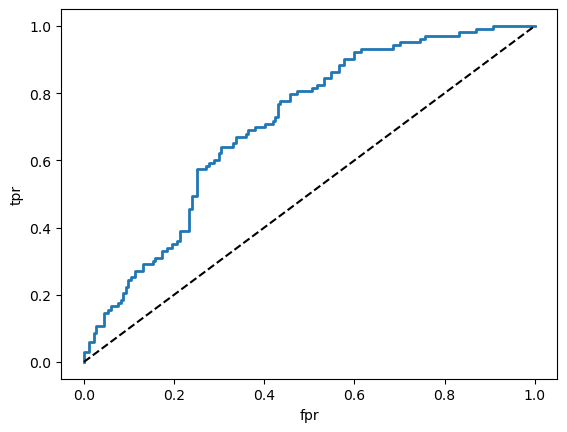

In [560]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

In [561]:
classification_report(test_y, pred_y, output_dict=True)

{'0.0': {'precision': 0.851063829787234,
  'recall': 0.43478260869565216,
  'f1-score': 0.5755395683453237,
  'support': 184.0},
 '1.0': {'precision': 0.46113989637305697,
  'recall': 0.8640776699029126,
  'f1-score': 0.6013513513513513,
  'support': 103.0},
 'accuracy': 0.5888501742160279,
 'macro avg': {'precision': 0.6561018630801455,
  'recall': 0.6494301392992824,
  'f1-score': 0.5884454598483375,
  'support': 287.0},
 'weighted avg': {'precision': 0.7111259721507872,
  'recall': 0.5888501742160279,
  'f1-score': 0.5848030305391246,
  'support': 287.0}}

[cv=4] 정확도:0.5889, 정밀도:0.4611, 재현율:0.8641  
[cv=5] 정확도:0.6237, 정밀도:0.4866, 재현율:0.8835  
=> cv가 5일 때 모든 지표가 향상된 것을 확인해볼 수 있음  
=> 동일한 bagging 모델(RandomForestClassifier, BaggingClassifier) 사용하는 것보다 xgboost모델을 bagging 하는 것이 정확도와 정밀도는 감소하나  재현율 증가   
=> 어느 모델이 더 좋다고 말하기는 어려워보임

## 3. 모델 변경 (RandomForestClassifier 단일 사용), 매개변수 변경
- RandomForest, BaggingClassifier 함께 사용하면 안정적 예측 가능하나 시간 많이 소요되므로 RandomForest만 사용
- 경험상 RandomForest는 튜닝 없이 default한 모델일 때 가장 높은 성능이 나온 경우가 많았으므로 튜닝 없이 진행

In [574]:
train_x, test_x, train_y, test_y = data_split(0.6, 0.3)

In [575]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=11)

In [576]:
rfc.fit(train_x, train_y)
pred_y = rfc.predict(test_x)
prob_y = rfc.predict_proba(test_x)

In [577]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}')

================= confusion matrix ====================
[[94 90]
 [17 86]]
정확도:0.6272, 정밀도:0.4886, 재현율:0.8350


auc:0.7351203039257069


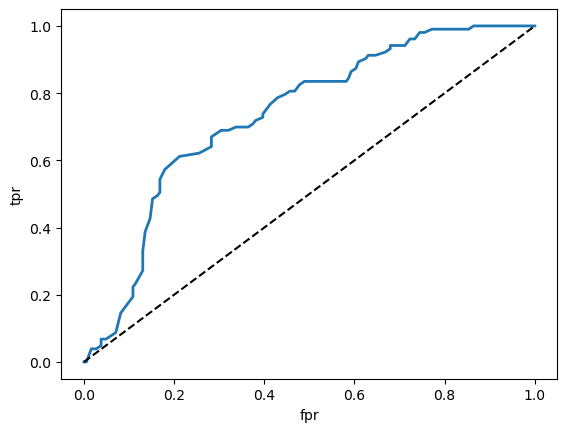

In [578]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

In [579]:
classification_report(test_y, pred_y, output_dict=True)

{'0.0': {'precision': 0.8468468468468469,
  'recall': 0.5108695652173914,
  'f1-score': 0.6372881355932203,
  'support': 184.0},
 '1.0': {'precision': 0.48863636363636365,
  'recall': 0.8349514563106796,
  'f1-score': 0.6164874551971327,
  'support': 103.0},
 'accuracy': 0.627177700348432,
 'macro avg': {'precision': 0.6677416052416052,
  'recall': 0.6729105107640354,
  'f1-score': 0.6268877953951765,
  'support': 287.0},
 'weighted avg': {'precision': 0.7182904713392518,
  'recall': 0.627177700348432,
  'f1-score': 0.6298230830468892,
  'support': 287.0}}

[이전 모델] 정확도:0.6237, 정밀도:0.4866, 재현율:0.8835  
[현재 모델] 정확도:0.6272, 정밀도:0.4886, 재현율:0.8350  
=> 정확도와 정밀도는 비슷하나 재현율이 떨어진 것을 확인할 수 있음    
=> 위와 동일하게 xgboost의 성능이 더 높은 것을 확인 가능

## 4. validation 추가해 과적합 확인 (RandomForestClassifier, LogisticRegression)

In [456]:
from sklearn.linear_model import LogisticRegression

In [585]:
train_x, test_x, train_y, test_y = data_split(0.6, 0.3)

In [586]:
n_tr = int(np.round(len(train_x) * train_ratio))
n_val = int(np.round(len(train_x) * test_ratio))

x_tr, x_val, y_tr, y_val = train_x[:n_tr], train_x[-n_val:], train_y.iloc[:n_tr], train_y.iloc[-n_val:]

In [587]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=11)

In [588]:
lr.fit(x_tr, y_tr)
pred_y = lr.predict(x_val)
prob_y = lr.predict_proba(x_val)

In [589]:
confusion = confusion_matrix(y_val, pred_y)
accuracy  = accuracy_score(y_val, pred_y)
precision = precision_score(y_val, pred_y)
recall    = recall_score(y_val, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}')

================= confusion matrix ====================
[[44 74]
 [14 40]]
정확도:0.4884, 정밀도:0.3509, 재현율:0.7407


In [590]:
lr.fit(train_x, train_y)
pred_y = lr.predict(test_x)
prob_y = lr.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}')

================= confusion matrix ====================
[[122  62]
 [  9  94]]
정확도:0.7526, 정밀도:0.6026, 재현율:0.9126


auc:0.8606479527226678


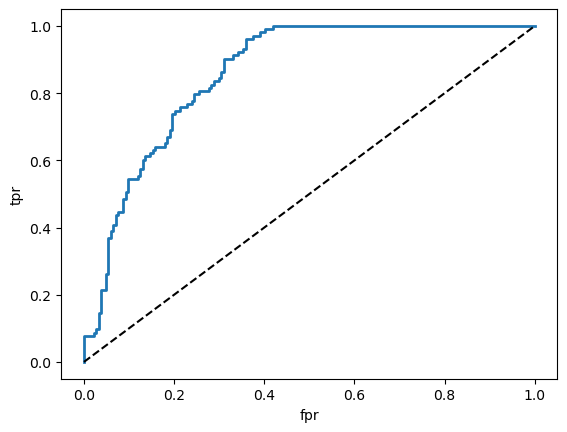

In [591]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

In [592]:
classification_report(test_y, pred_y, output_dict=True)

{'0.0': {'precision': 0.9312977099236641,
  'recall': 0.6630434782608695,
  'f1-score': 0.7746031746031746,
  'support': 184.0},
 '1.0': {'precision': 0.6025641025641025,
  'recall': 0.912621359223301,
  'f1-score': 0.7258687258687259,
  'support': 103.0},
 'accuracy': 0.7526132404181185,
 'macro avg': {'precision': 0.7669309062438834,
  'recall': 0.7878324187420853,
  'f1-score': 0.7502359502359502,
  'support': 287.0},
 'weighted avg': {'precision': 0.8133201435193615,
  'recall': 0.7526132404181185,
  'f1-score': 0.7571131111200798,
  'support': 287.0}}

- randomforest  
검증: 정확도:0.6567, 정밀도:0.6329, 재현율:0.9009  
테스트: 정확도:0.6335, 정밀도:0.4286, 재현율:0.8182  
=> 테스트 데이터에서 성능이 떨어진 것으로 보아 훈련데이터 과적합을 의심해볼 수 있음  
=> 트리기반 모델 대신 더 단순한 LogisticRegression 알고리즘 사용 시도

- LogisticRegression  
[검증] 정확도:0.4884, 정밀도:0.3509, 재현율:0.7407  
[테스트]: 정확도:0.7526, 정밀도:0.6026, 재현율:0.9126  
=> 과적합은 개선되어보이나 테스트 데이터에서 성능이 눈에 띄게 향상된 것을 볼 수 있음  
=> 데이터의 수가 적어 모델이 우연에 의해 테스트 데이터에 잘 맞은 것으로 보임  
=> 그럼에도 기준점수보단 정확도, 정밀도, 재현율 모두에서 더 높은 점수를 보임
